# Credit Card Fraud Detection

---

**Table of Contents** 

[1.0 Objectives](#1.0-Objectives)  
[2.0 Import Library](#2.0-Import-Library)  
[3.0 Set Constant and Default Settings](#3.0-Set-Constant-and-Default-Settings)  
[4.0 Load Dataset](#4.0-Load-Dataset)  
[5.0 Split dataset into train and test set](#5.0-Split-dataset-into-train-and-test-set)  
[6.0 Exploratory Data Analysis (EDA)](#6.0-Exploratory-Data-Analysis-%28EDA%29)  
&nbsp; &nbsp; &nbsp; [6.1 Statistics Summary of Dataset](#6.1-Statistics-Summary-of-Dataset)  
&nbsp; &nbsp; &nbsp; [6.2 Detect for Outliers](#6.2-Detect-for-Outliers)   
&nbsp; &nbsp; &nbsp; [6.3 Data Cleaning](#6.3-Data-Cleaning)   
&nbsp; &nbsp; &nbsp; [6.4 Feature Scaling](#6.4-Feature-Scaling)   
&nbsp; &nbsp; &nbsp; [6.5 Full Transformation](#6.5-Full-Transformation)   
[7.0 Model Evaluation Metrics](#7.0-Model-Evaluation-Metrics)   
[8.0 Machine Learning Model](#8.0-Machine-Learning-Model)  
&nbsp; &nbsp; &nbsp; [8.1 Benchmark Model - Logistic Regression](#8.1-Benchmark-Model-\--Logistic-Regression)  
&nbsp; &nbsp; &nbsp; [8.2 Other Models](#8.2-Other-Models)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [8.2.1 Stochastic Gradient Descent (SGD) Classifier](#8.2.1-Stochastic-Gradient-Descent-%28SGD%29-Classifier)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [8.2.2 Random Forest Classifier](#8.2.2-Random-Forest-Classifier)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [8.2.3 Support Vector Machine Classifier](#8.2.3-Support-Vector-Machine-Classifier)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; [8.2.4 Naive Bayes](#8.2.4-Naive-Bayes)  
&nbsp; &nbsp; &nbsp; [8.3 Model Selection](#8.3-Model-Selection)  
&nbsp; &nbsp; &nbsp; [8.4 Fine-Tuning Model](#8.4-Fine-Tuning-Model)  
&nbsp; &nbsp; &nbsp; [8.5 Resample on Dataset](#8.5-Resample-on-Dataset)  
&nbsp; &nbsp; &nbsp; [8.6 Initialise Class Weight on Model](#8.6-Initialise-Class-Weight-on-Model)  
[9.0 Conclusion](#9.0-Conclusion)  

---

# 1.0 Objectives

- To build a model that detect credit card fraud

# 2.0 Import Library

In [1]:
# System
import os

# Parallel
from joblib import effective_n_jobs

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Preprocessing data
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import f1_score, recall_score

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Fine-tune
from sklearn.model_selection import RandomizedSearchCV

# Resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 3.0 Set Constant and Default Settings

In [3]:
plt.rcParams['figure.dpi'] = 150
sns.set_style('dark')

In [4]:
base_dir = os.path.join('/', 'kaggle', 'input', 'creditcardfraud')

# Check if kaggle env or local env
is_kaggle = os.path.exists(base_dir)

dataset_path = os.path.join(base_dir if is_kaggle else '', 'creditcard.csv')

In [5]:
n_thread =  effective_n_jobs(-1)

if not is_kaggle:
    n_thread =  int(effective_n_jobs(-1) * 0.7)

# 4.0 Load Dataset

In [6]:
df = pd.read_csv(dataset_path)

# 5.0 Split dataset into train and test set

In [7]:
X_df = df.drop(['Class'], axis=1)
y_df = df['Class']

In [8]:
train_test_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in train_test_sss.split(X_df, y_df):
    train_df = df.loc[train_index]
    test_df = df.loc[test_index]

In [9]:
X_train_df = train_df.drop(['Class'], axis=1)
y_train_df = train_df['Class']

In [10]:
train_val_sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in train_val_sss.split(X_train_df, y_train_df):
    train_df = df.loc[train_index]
    val_df = df.loc[val_index]

# 6.0 Exploratory Data Analysis (EDA)

## 6.1 Statistics Summary of Dataset

In [11]:
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
225121,144115.0,2.260499,-0.672775,-1.730349,-1.186476,0.113699,-0.361084,-0.310538,-0.206716,-0.739631,...,0.013536,0.101338,0.052963,-1.133791,0.107662,-0.226698,-0.037289,-0.085215,4.45,0
61995,50083.0,0.474826,-1.600174,0.372791,-0.602230,-1.298861,-0.120802,-0.128786,-0.029808,1.403290,...,0.416361,0.612892,-0.541799,0.104079,0.533606,-0.573770,0.024304,0.089797,391.30,0
197454,132022.0,2.038625,-0.197583,-1.477283,0.166705,0.089200,-0.691551,-0.035744,-0.053390,0.620787,...,0.270211,0.776487,0.051810,0.746167,0.185787,-0.157799,-0.041134,-0.065754,1.00,0
116739,74407.0,-1.269508,2.384286,-1.008598,0.933525,-0.551805,-1.306949,0.001500,0.960055,-0.855683,...,0.216123,0.644880,0.181321,0.428130,-0.491161,-0.403557,0.284246,0.165831,2.28,0
169028,119492.0,2.040578,-0.146368,-2.955721,-0.578510,2.609546,3.142573,-0.417135,0.784442,0.359925,...,-0.352449,-0.996836,0.363652,0.604817,-0.264490,0.219691,-0.039174,-0.042820,1.79,0


In [12]:
train_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Due to privacy issues, the dataset feature name has been masked and been named 'V1', 'V2' and etc.

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182276 entries, 225121 to 100485
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    182276 non-null  float64
 1   V1      182276 non-null  float64
 2   V2      182276 non-null  float64
 3   V3      182276 non-null  float64
 4   V4      182276 non-null  float64
 5   V5      182276 non-null  float64
 6   V6      182276 non-null  float64
 7   V7      182276 non-null  float64
 8   V8      182276 non-null  float64
 9   V9      182276 non-null  float64
 10  V10     182276 non-null  float64
 11  V11     182276 non-null  float64
 12  V12     182276 non-null  float64
 13  V13     182276 non-null  float64
 14  V14     182276 non-null  float64
 15  V15     182276 non-null  float64
 16  V16     182276 non-null  float64
 17  V17     182276 non-null  float64
 18  V18     182276 non-null  float64
 19  V19     182276 non-null  float64
 20  V20     182276 non-null  float64
 21  V21  

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.918649e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.682686e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.761736e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.811118e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552103e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.040130e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.698953e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.893285e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.147640e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


As stated from the dataset author, the feature in the dataset is obtained from PCA. The only features that not obtained from PCA are 'Amount' and 'Time'. Standard scaler is required to apply on these two features. It is to avoid the model to have a false sense of feature 'Amount' and 'Time' is more significant than the rest of features when model being trained.

In [15]:
label_weight_perc = train_df['Class'].value_counts(normalize=True) * 100

label_weight_perc

0    99.816761
1     0.183239
Name: Class, dtype: float64

Another interesting fact is that the dataset label is extremely imbalanced. 99.83% of the instances in the dataset is not fraud while only 0.17% of the instances are fraud. This will lead the model training extremely difficult and appropriate metrics to measure the model is required.

In [16]:
train_df.corr()['Class'].sort_values()

V17      -0.362884
V14      -0.313362
V12      -0.269756
V10      -0.238518
V16      -0.219037
V3       -0.215121
V7       -0.214055
V18      -0.128889
V1       -0.111857
V5       -0.109178
V9       -0.101438
V6       -0.044186
Time     -0.013098
V24      -0.007756
V15      -0.005866
V23      -0.003444
V13      -0.001646
V25      -0.000684
V22       0.000467
V26       0.000546
Amount    0.004786
V28       0.009031
V8        0.015440
V20       0.017704
V27       0.021062
V19       0.038386
V21       0.052034
V2        0.100242
V4        0.137693
V11       0.165494
Class     1.000000
Name: Class, dtype: float64

## 6.2 Detect for Outliers

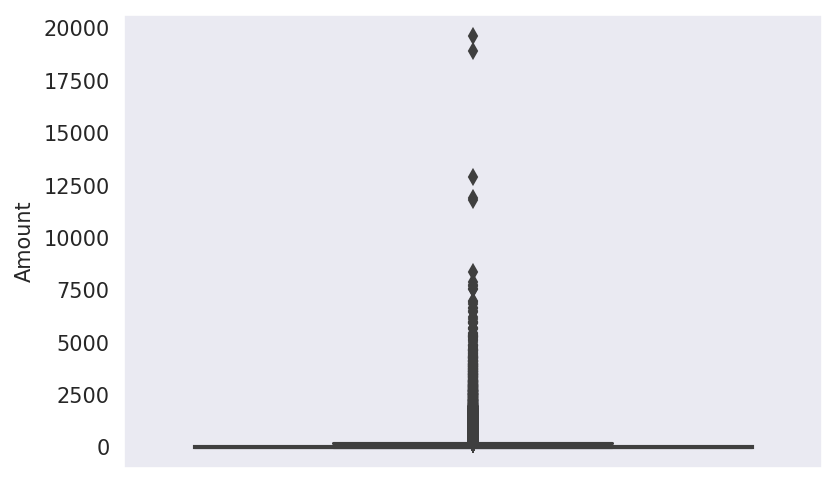

In [17]:
sns.boxplot(data=train_df, y='Amount')

plt.show()

From above graph, we can see the box plot for the feature 'Amount' contains outlier

In [18]:
feature_outlier = dict()

class Outlier:
    def __init__(self, q1, q3):
        self.q1 = q1
        self.q3 = q3
        self.iqr = q3 - q1
    
    def get_outlier_boundary(self):
        lower_fence = self.q1 - 1.5 * self.iqr
        upper_fence = self.q3 + 1.5 * self.iqr
        
        return lower_fence, upper_fence


def filter_outlier(df, cols=[]):
    if 'is_outlier' not in df.columns:
        df['is_outlier'] = (False) * len(df)
        
    for col in cols:
        if col in feature_outlier.keys():
            outlier = feature_outlier[col]
        else:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            
            outlier = Outlier(q1, q3)
            feature_outlier[col] = outlier
             
        lower_fence, upper_fence = outlier.get_outlier_boundary()
        
        outlier = (df[col] < lower_fence) | (df[col] > upper_fence)
        
        df['is_outlier'] = outlier | df['is_outlier']
        
    df = df[~df['is_outlier']]
    df = df.drop(['is_outlier'], axis=1)
             
    return df

In [19]:
train_df = filter_outlier(train_df, cols=['Amount'])

## 6.3 Data Cleaning

In [20]:
train_df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Data cleaning is not required as the dataset has been cleaned by the dataset author.

## 6.4 Feature Scaling

Applying standardisation to the feature 'Amount' and 'Time'

In [21]:
std_feat = ['Amount', 'Time']
std_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

## 6.5 Full Transformation

In [22]:
full_pipeline = ColumnTransformer([
    ('std_feat', std_pipeline, std_feat)
], remainder='passthrough')

In [23]:
X_train = train_df.drop(['Class'], axis=1)
y_train = train_df['Class']

X_train = full_pipeline.fit_transform(X_train)

In [24]:
X_val = val_df.drop(['Class'], axis=1)
y_val = val_df['Class']

X_val = full_pipeline.transform(X_val)

In [25]:
X_test = test_df.drop(['Class'], axis=1)
y_test = test_df['Class']

X_test = full_pipeline.transform(X_test)

# 7.0 Model Evaluation Metrics

Since the dataset label is extremely imbalanced, only 0.18% of instances in the dataset is fraud. Selecting an appropriate evaluation metrics is crucial as standard metrics work well on balanced dataset. 

For example, using the accuracy as metrics for this dataset. The model can just predict all the instances in the dataset as non-fraud and accuracy of the model still be 99.82%. As 99.82% of the instances in the dataset is non-fraud.

Hence, we need to select 'recall' and 'f1-score' as the metrics to evaluate the model.

$$Recall = \frac{True~Positive}{True~Positive + False~Negative}$$

$$F1~Score = \frac{2 \times Precision \times Recall}{Precision + Recall}$$

In [26]:
model_eval = {
    'model': [],
    'recall': [],
    'f1_score': []
}

def add_model_eval(model, recall, f1_score):
    model_eval['model'].append(model)
    model_eval['recall'].append(f'{recall: .2f}')
    model_eval['f1_score'].append(f'{f1_score: .2f}')
    
def view_models_eval(sort=False):
    eval_df = pd.DataFrame(model_eval)
    
    if sort:
        eval_df = eval_df.sort_values(by=['recall', 'f1_score'], ascending=[False, False])
    
    display(eval_df.style.hide_index())

# 8.0 Machine Learning Model

## 8.1 Benchmark Model - Logistic Regression

The benchmark model for classify credit card instance is fraud or non-fraud will be logistic regression. A logistic regression is the most common model for binary classification.

In [27]:
log_reg = LogisticRegression(random_state=42, verbose=1)
log_reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12286D+05    |proj g|=  8.07180D+04

At iterate   50    f=  6.18153D+02    |proj g|=  4.81710D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     76     85      1     0     0   3.591D-02   6.181D+02
  F =   618.14402077199816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished


LogisticRegression(random_state=42, verbose=1)

In [28]:
y_pred = log_reg.predict(X_val)

add_model_eval('logistic regression', recall_score(y_val, y_pred), f1_score(y_val, y_pred))

In [29]:
view_models_eval()

model,recall,f1_score
logistic regression,0.51,0.63


Based on logistic regression, the recall and f1_score are 0.51 and 0.63 respectively. With a recall of 0.51, the model able to detect about half of the fraud instances correctly. There still room to improve the metric score. Let try other model with default parameter first and compare to logistic regression before fine-tune the logistic regression.

## 8.2 Other Models

Below the list of model will be trained to classify the credit card dataset as fraud or non-fraud:
- Stochastic Gradient Descent (SGD) Classifier
- Random Forest Classifier
- Support Vector Machine Classifier
- Naive Bayes

### 8.2.1 Stochastic Gradient Descent (SGD) Classifier

In [30]:
sgd_clf = SGDClassifier(random_state=42, verbose=1)
sgd_clf.fit(X_train, y_train)

-- Epoch 1
Norm: 20.21, NNZs: 30, Bias: -205.779552, T: 161994, Avg. loss: 0.186151
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 20.22, NNZs: 30, Bias: -201.759114, T: 323988, Avg. loss: 0.090558
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 18.23, NNZs: 30, Bias: -199.595128, T: 485982, Avg. loss: 0.084583
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 18.94, NNZs: 30, Bias: -197.861440, T: 647976, Avg. loss: 0.085741
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 18.85, NNZs: 30, Bias: -196.565582, T: 809970, Avg. loss: 0.083475
Total training time: 0.18 seconds.
-- Epoch 6
Norm: 18.92, NNZs: 30, Bias: -195.497796, T: 971964, Avg. loss: 0.082176
Total training time: 0.22 seconds.
-- Epoch 7
Norm: 18.51, NNZs: 30, Bias: -194.637519, T: 1133958, Avg. loss: 0.080905
Total training time: 0.26 seconds.
-- Epoch 8
Norm: 18.67, NNZs: 30, Bias: -193.845960, T: 1295952, Avg. loss: 0.081004
Total training time: 0.29 seconds.
-- Epoch 9
Norm: 18.65, NNZs: 30, Bias: -193.1

SGDClassifier(random_state=42, verbose=1)

In [31]:
y_pred = sgd_clf.predict(X_val)

add_model_eval('sgd classifier', recall_score(y_val, y_pred), f1_score(y_val, y_pred))

In [32]:
view_models_eval()

model,recall,f1_score
logistic regression,0.51,0.63
sgd classifier,0.47,0.60


### 8.2.2 Random Forest Classifier

In [33]:
forest_clf = RandomForestClassifier(random_state=42, verbose=2, n_jobs=n_thread)
forest_clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.7s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   49.6s finished


RandomForestClassifier(n_jobs=4, random_state=42, verbose=2)

In [34]:
y_pred = forest_clf.predict(X_val)

add_model_eval('random forest classifier', recall_score(y_val, y_pred), f1_score(y_val, y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [35]:
view_models_eval()

model,recall,f1_score
logistic regression,0.51,0.63
sgd classifier,0.47,0.60
random forest classifier,0.78,0.86


### 8.2.3 Support Vector Machine Classifier

In [36]:
svm_clf = SVC(random_state=42, verbose=2)
svm_clf.fit(X_train, y_train)

[LibSVM]..
*..*
optimization finished, #iter = 4462
obj = -224.694419, rho = -0.728710
nSV = 1937, nBSV = 138
Total nSV = 1937


SVC(random_state=42, verbose=2)

In [37]:
y_pred = svm_clf.predict(X_val)

add_model_eval('support vector machine classifier', recall_score(y_val, y_pred), f1_score(y_val, y_pred))

In [38]:
view_models_eval()

model,recall,f1_score
logistic regression,0.51,0.63
sgd classifier,0.47,0.60
random forest classifier,0.78,0.86
support vector machine classifier,0.60,0.73


### 8.2.4 Naive Bayes

In [39]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [40]:
y_pred = svm_clf.predict(X_val)

add_model_eval('naive bayes', recall_score(y_val, y_pred), f1_score(y_val, y_pred))

In [41]:
view_models_eval()

model,recall,f1_score
logistic regression,0.51,0.63
sgd classifier,0.47,0.60
random forest classifier,0.78,0.86
support vector machine classifier,0.60,0.73
naive bayes,0.60,0.73


## 8.3 Model Selection

In [42]:
view_models_eval(sort=True)

model,recall,f1_score
random forest classifier,0.78,0.86
support vector machine classifier,0.60,0.73
naive bayes,0.60,0.73
logistic regression,0.51,0.63
sgd classifier,0.47,0.60


From the above table, we can know that random forest classifier model has the highest recall and f1_score by using default parameter. Thus, we will use random forest classifier to predict fraud and non-fraud for the dataset.

## 8.4 Fine-Tuning Model

Now, let try to fine-tune the parameter of the random forest classifier.

In [43]:
# clf = classifier
# ft = fine-tune
forest_clf_ft = RandomForestClassifier(random_state=42, n_jobs=n_thread)

param_grid = {
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300, 400, 500]
}

random_search = RandomizedSearchCV(forest_clf_ft, 
                                   param_grid, 
                                   random_state=42,
                                   cv=2,
                                   n_iter=10, 
                                   scoring='recall',
                                   verbose=2)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.6min
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.6min
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  57.1s
[CV] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  59.1s
[CV] END bootstrap=False, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.2min
[CV] END bootstrap=False, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time= 2.2min
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time= 1.3min
[CV] END bootstrap=True, max_features=sqrt, min_samples_leaf=4, min_samples_split

RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(n_jobs=4, random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='recall', verbose=2)

In [44]:
forest_clf_best_params = random_search.best_params_

forest_clf_best_params

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'bootstrap': True}

In [45]:
y_pred = random_search.predict(X_val)

add_model_eval('random forest classifier with fine-tune', recall_score(y_val, y_pred), f1_score(y_val, y_pred))

In [46]:
view_models_eval()

model,recall,f1_score
logistic regression,0.51,0.63
sgd classifier,0.47,0.60
random forest classifier,0.78,0.86
support vector machine classifier,0.60,0.73
naive bayes,0.60,0.73
random forest classifier with fine-tune,0.80,0.86


After fine-tune the random forest classifier, the model has a slightly increase on recall than default parameter.

## 8.5 Resample on Dataset

Besides, getting the optimum parameter for the random forest classifier model. We also can leverage the resampling technique on the dataset to make the label balance.

First, use the SMOTE to oversample of the minority class Next, use random undersampling to reduce the number of instances of majority class. In the end, the ratio of non-fraud and fraud will be $1 : 1$

In [47]:
pd.Series(y_train).value_counts(normalize=True)

0    0.998278
1    0.001722
Name: Class, dtype: float64

Before resample, the ratio of non-fraud to fraud is $99 : 1$

In [48]:
oversampling = SMOTE(random_state=42)
undersampling = RandomUnderSampler(random_state=42)
steps = [('o', oversampling), ('u', undersampling)]
pipeline = Pipeline(steps=steps)

In [49]:
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [50]:
pd.Series(y_train_resampled).value_counts(normalize=True)

0    0.5
1    0.5
Name: Class, dtype: float64

After resample, the ratio of non-fraud to fraud is $1 : 1$

In [51]:
# clf = classifier
# ft = fine-tune
# rs = resample
forest_clf_ft_rs = RandomForestClassifier(**forest_clf_best_params,
                                       random_state=42, 
                                       verbose=2, 
                                       n_jobs=n_thread)

forest_clf_ft_rs.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   31.5s



building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100building tree 60 of 100

building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 7

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.6min finished


RandomForestClassifier(min_samples_leaf=2, n_jobs=4, random_state=42, verbose=2)

In [52]:
y_pred = forest_clf_ft_rs.predict(X_val)

add_model_eval('random forest classifier with fine-tune and resample', recall_score(y_val, y_pred), f1_score(y_val, y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [53]:
view_models_eval()

model,recall,f1_score
logistic regression,0.51,0.63
sgd classifier,0.47,0.60
random forest classifier,0.78,0.86
support vector machine classifier,0.60,0.73
naive bayes,0.60,0.73
random forest classifier with fine-tune,0.80,0.86
random forest classifier with fine-tune and resample,0.82,0.85


With the resampling technique apply to the train dataset, the model has recall score has improved from 0.80 to 0.82 while f1 decrease slightly to 0.85. Despite that, it is worth the trade.

## 8.6 Initialise Class Weight on Model

Lastly, let try to specify the class weight on the model to see whether any improvement will be made or not on the original train dataset (i.e. not the dataset been resampled)

In [54]:
# clf = classifier
# ft = fine-tune
# cw = class weight
forest_clf_ft_cw = RandomForestClassifier(**forest_clf_best_params,
                                       class_weight='balanced',
                                       random_state=42, 
                                       verbose=2, 
                                       n_jobs=n_thread)

forest_clf_ft_cw.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.7s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   29.5s finished


RandomForestClassifier(class_weight='balanced', min_samples_leaf=2, n_jobs=4,
                       random_state=42, verbose=2)

In [55]:
y_pred = forest_clf_ft_cw.predict(X_val)

add_model_eval('random forest classifier with fine-tune and class weight', recall_score(y_val, y_pred), f1_score(y_val, y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [56]:
view_models_eval()

model,recall,f1_score
logistic regression,0.51,0.63
sgd classifier,0.47,0.60
random forest classifier,0.78,0.86
support vector machine classifier,0.60,0.73
naive bayes,0.60,0.73
random forest classifier with fine-tune,0.80,0.86
random forest classifier with fine-tune and resample,0.82,0.85
random forest classifier with fine-tune and class weight,0.78,0.84


Despite having set the class weight on the random forest classifier model, the model recall and f1 score been decreased

# 9.0 Conclusion

In [57]:
view_models_eval(sort=True)

model,recall,f1_score
random forest classifier with fine-tune and resample,0.82,0.85
random forest classifier with fine-tune,0.80,0.86
random forest classifier,0.78,0.86
random forest classifier with fine-tune and class weight,0.78,0.84
support vector machine classifier,0.60,0.73
naive bayes,0.60,0.73
logistic regression,0.51,0.63
sgd classifier,0.47,0.60


After trying searching and tweaking different models, the model that score the highest for both recall and f1 score on the validation set will be random forest classifier with fine-tune and resample.

In [58]:
y_pred = forest_clf_ft_rs.predict(X_test)

recall_score(y_test, y_pred), f1_score(y_test, y_pred)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


(0.9387755102040817, 0.9435897435897437)

The model score 0.94 and 0.94 for recall and f1 score respectively on the test dataset. 